# Objectif du script
- Le script parcourt les annonces scrapées pour en extraire des entités nommées et en faire des features
- Le script va ensuite entraîner 2 modèles qui auront pour objectif de prédire un bonus / malus de prix en fonction des features : un modèle pour les maisons, un modèle pour les appartements

WARNiNG : l'exécution du script est longue

In [1]:
import pandas as pd
import re
import spacy
from string import punctuation
import unidecode
import matplotlib.pyplot as plt

from spacy import displacy
from spacy.tokens import Span

import joblib

In [2]:
import sklearn
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression, RFE, RFECV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
pd.set_option('display.max_columns', None) 

### Import du fichier d'annonces scrapées

In [4]:
df = pd.read_csv('databases/superimmo/superimmo_20211008_33.csv')
df2 = pd.read_csv('databases/superimmo/superimmo_20211008_13.csv')
df3 = pd.read_csv('databases/superimmo/superimmo_20211008_69.csv')

df = pd.concat([df, df2, df3])
df.head()

,Unnamed: 0,link,ref,agence,description,details,titre,prix_title,prix,taxe_fonciere,charges,orientation,classe_energie,build_date,DPE,surface,piece,chambre,location,type,terrain
0,0,https://www.superimmo.com/annonces/achat-maiso...,Publiée le 08/10/2021 - Réf. agence : TM512428...,Tanaïs Habitat Publiée le 08/10/2021 Réf. agen...,MAISON À CONSTUIRE : ceci est une annonce d'un...,NaN,Vente maison neuve 125 m² - 5 pièces - 4 chamb...,389 350 €,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125,5 pièces,4 chambres,Belin-Béliet (33830),maison neuve,ter. 466 m²
1,1,https://www.superimmo.com/annonces/achat-maiso...,Publiée le 08/10/2021 - Réf. agence : TM512433...,Tanaïs Habitat Publiée le 08/10/2021 Réf. agen...,MAISON À CONSTUIRE : ceci est une annonce d'un...,NaN,Vente maison neuve 145 m² - 5 pièces - 4 chamb...,392 075 €,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145,5 pièces,4 chambres,Belin-Béliet (33830),maison neuve,ter. 466 m²
2,2,https://www.superimmo.com/annonces/achat-maiso...,Publiée le 08/10/2021 - Réf. agence : TM512400...,Tanaïs Habitat Publiée le 08/10/2021 Réf. agen...,MAISON À CONSTUIRE : ceci est une annonce d'un...,NaN,Vente maison neuve 150 m² - 5 pièces - 4 chamb...,500 850 €,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,5 pièces,4 chambres,Montussan (33450),maison neuve,ter. 495 m²
3,3,https://www.superimmo.com/annonces/achat-maiso...,Publiée le 08/10/2021 - Réf. agence : TM512399...,Tanaïs Habitat Publiée le 08/10/2021 Réf. agen...,MAISON À CONSTUIRE : ceci est une annonce d'un...,NaN,Vente maison neuve 145 m² - 5 pièces - 4 chamb...,485 400 €,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145,5 pièces,4 chambres,Montussan (33450),maison neuve,ter. 495 m²
4,4,https://www.superimmo.com/annonces/achat-maiso...,Publiée le 08/10/2021 - Réf. agence : TM512436...,Tanaïs Habitat Publiée le 08/10/2021 Réf. agen...,MAISON À CONSTUIRE : ceci est une annonce d'un...,NaN,Vente maison neuve 155 m² - 5 pièces - 4 chamb...,416 873 €,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155,5 pièces,4 chambres,Belin-Béliet (33830),maison neuve,ter. 466 m²


In [5]:
df.shape

(32543, 21)

In [6]:
df.columns

Index(['Unnamed: 0', 'link', 'ref', 'agence', 'description', 'details',
       'titre', 'prix_title', 'prix', 'taxe_fonciere', 'charges',
       'orientation', 'classe_energie', 'build_date', 'DPE', 'surface',
       'piece', 'chambre', 'location', 'type', 'terrain'],
      dtype='object')

### Suppression des annonces de maisons et appartements neufs

In [7]:
df['type'].value_counts()

appartement         11267
maison              10346
maison neuve         6113
appartement neuf     4308
Name: type, dtype: int64

In [8]:
# Suppression des maisons et appartements neufs, on ne conserve que les annonces qui se rapportent à l'ancien
df = df[(df['type'] == 'maison') | (df['type'] == 'appartement')]
df.shape

(21613, 21)

### Cleaning de la base de données

#### Récupération du code postal

In [9]:
def return_code_postal(text):
    try:
        result = re.findall('[0-9]{5}',text)[0]
    except:
        result = ''
    return result

df['code_postal'] = df['location'].apply(lambda x: return_code_postal(x))

#### Formatage des variables numériques (prix, surface du terrain, nb pieces, nb chambres)

In [10]:
df['prix_title'] = df['prix_title'].replace(['€', ' '], ['', ''], regex = True)
df['prix'] = df['prix'].replace(['€', ' '], ['', ''], regex = True)

df['prix'] = df.apply(lambda x: x['prix_title'] if x['prix'] == "NaN" else x['prix'], axis = 1)

In [11]:
df['surface_terrain'] = df['terrain'].replace(['ter.', 'm²', ' '], ['', '', ''], regex = True)
df['nb_pieces'] = df['piece'].replace(['pièces', 'pièce', ' '], ['', '', ''], regex = True)
df['nb_chambres'] = df['chambre'].replace(['chambres', 'chambre', ' '], ['', '', ''], regex = True)

df = df.drop(columns = {'prix_title', 'terrain', 'piece', 'chambre'})

In [12]:
df.isna().sum()

Unnamed: 0             0
link                   0
ref                  140
agence                 0
description           96
details                0
titre                  0
prix                 102
taxe_fonciere      17424
charges            13862
orientation        15130
classe_energie     12624
build_date         11021
DPE                11562
surface                0
location               0
type                   0
code_postal            0
surface_terrain    13581
nb_pieces              0
nb_chambres         2194
dtype: int64

#### Formatage de la description

In [13]:
def preprocess_text(text):
    text = text.lower()  # Lowercase text
    #text = re.sub(f"[{re.escape(punctuation)}]", " ", text)  # Remove punctuation
    text = " ".join(text.split())  # Remove extra spaces, tabs, and new lines
    text = unidecode.unidecode(text)
    return text

df = df.dropna(axis = 0, how = 'all', subset = ['description'])
df['desc_clean'] = df['description'].map(preprocess_text)

#### Récupération du nom de l'agence

In [14]:
df['agence_only'] = df['agence'].apply(lambda x: x.split('Publiée')[0])

#### Suppression des annonces en double basée sur la description

In [15]:
df = df.drop_duplicates(subset = 'desc_clean').drop(columns = {'Unnamed: 0'}).reset_index()

#### Vérification post processing

In [16]:
df.shape

(21087, 23)

In [17]:
# Exemples de descriptions
for i in range(10):
    print(i, "/", "\n", df['desc_clean'][i])
    print("\n")

0 / 
 contemporaine de plain pied a la decoration soignee. cette maison vous offre de belles prestations : cuisine et salle de bain haut de gamme, terrasse bois. composee de 3 chambres, un bureau et une extension a terminer, elle vous seduira par ses beaux volumes et sa parcelle agreable.


1 / 
 maison contemporaine composee de 3 chambres, garage, sur un terrain d'environ 1850 m2. possibilite de construire une deuxieme maison sur le terrain.


2 / 
 sur une commune proche de cavignac, a proximite d'une gare et des ecoles a pied (de la garderie jusqu'au college). maison en pierre avec un fort potentiel d'amenagement, garage attenant. ainsi qu'une grange independante rehabilitable de plus de 170 m2 au sol sur un terrain d'environ 1500 m2. plusieurs entrees sur le terrain.


3 / 
 situee dans un environnement calme et residentiel a seulement 10 minutes de bordeaux , venez decouvrir cette spacieuse villa offrant entree, salon, salle a manger, veranda de 33m2, cuisine, 5 chambres, mezzanin

### Extraction d'entités relatives aux annonces immobilières

In [18]:
nlp = spacy.load('fr_core_news_md')

In [19]:
# nlp.max_length = 5000000

In [20]:
# Write a function to display basic entity info:
def show_ents(doc):
    if doc.ents:
        for ent in doc.ents:
            print(ent.text+' - '+ent.label_+' - '+str(spacy.explain(ent.label_)))
    else:
        print('No named entities found.')

In [21]:
# Constitution du corpus

n_lines = df.shape[0]
text = ""

for i in range(0, 1000):
    annonce_desc = df['desc_clean'][i]
    text += annonce_desc

doc = nlp(text)

In [22]:
# Import PhraseMatcher and create a matcher object:
from spacy.matcher import PhraseMatcher
matcher = PhraseMatcher(nlp.vocab)

####  Générer des couleurs pour chaque entité nommée

In [23]:
import seaborn as sns
palette = "hls"

color_pal = sns.color_palette(palette, as_cmap = False, n_colors = 20)
color_pal = color_pal.as_hex()

color_pal

['#db5f57',
 '#db8657',
 '#dbae57',
 '#dbd657',
 '#b9db57',
 '#91db57',
 '#69db57',
 '#57db6c',
 '#57db94',
 '#57dbbb',
 '#57d3db',
 '#57acdb',
 '#5784db',
 '#575cdb',
 '#7957db',
 '#a157db',
 '#c957db',
 '#db57c6',
 '#db579e',
 '#db5777']

In [24]:
color_list = []
feature_name_list = []
colors = {}

def add_immo_feature(feature_name, liste):
    list_p = [nlp(item) for item in liste]
    matcher.add(feature_name, None, *list_p)

    feature_name_list.append(feature_name)
    color_list.append(color_pal[len(color_list)%20])

#### Définition du dictionnaire d'entités

In [25]:
immo_features = {
    'Exposition_Sud': ['exposition sud', 'expose plein sud', 'exposition plein sud', 'oriente sud', 'orientation sud', 
                       'plein sud', 'expose sud', 'exposition sud ouest', 'exposition sud-ouest', 'exposition sud est',
                      'exposition sud-est'],
    
    'Lumineux': ['ensoleillement', 'ensoleille', 'lumineux', 'lumineuse', 'clair', 'claire', 'lumiere', 'luminosite', 'soleil'],
    'Calme': ['calme', 'tranquille', 'preserve', 'preservee', 'double vitrage', 'silencieux'],
    'Volume': ['hauteur sous plafond', 'beau volume', 'beaux volumes', 'grands volumes', 'spacieux', 'vaste'],
    'Standing': ['standing', 'luxe', 'luxueux', 'luxueuse', 'moulures', 'dorures', 'pierre de taille', 'prestige'],
    'Charme': ['poutre', 'poutres', 'colombage', 'colombages', 'charme', 'charmant', 'coup de coeur', 'cheminee'],
    'Mezzanine': ['mezzanine', 'mezanine'],
    'Avec_Ascenseur': ['avec ascenseur', 'avec asc'],
    'Sans_Ascenseur': ['sans asc', 'sans ascenseur'],
    'Duplex': ['duplex', 'sur 2 etages'],
    'Dernier_etage': ['dernier etage'],
    'Premier_etage': ['1er etage', 'premier etage'],
    'Deuxieme_etage': ['2eme etage', 'deuxieme etage'],
    'Troisieme_etage': ['3eme etage', 'troisieme etage'],
    'Quatrieme_etage': ['4eme etage', 'quatrieme etage'],
    'Cinquieme_etage': ['5eme etage', 'cinquieme etage'],
    'Sixieme_etage': ['6eme etage', 'sixieme etage'],
    'Septieme_etage': ['7eme etage', 'septieme etage'],
    'Huitieme_etage': ['8eme etage', 'huitieme etage'],
    'RDC': ['rdc', 'rez de chaussee', 'rez-de-chaussee'],
    'Design': ['architecte', 'design'],
    'Terrasse': ['terrasse', 'balcon', 'loggia'],
    'Parfait_etat': ['refait', 'renove', 'moderne', 'refait a neuf', 'entierement refait', 'parfait etat', 
                     'sans travaux', 'aucun travaux'],
    'Travaux': ['travaux a prévoir', 'rafraichissement à prevoir', 'a rafraichir', 'renovation à prevoir'],
    'Proche_commodites': ['proche commodites', 'proche commerces'],
    'Vue_degagee': ['vue degagee', 'vue entierement degagee', 'vue totalement degagee', 'sans vis-a-vis', 'vis a vis'],
    'Securise': ['securise', 'gardien', 'gardienne', 'gardiens', 'digicode', 'interphone', 'serrure blindee'],
    'Emplacement': ['emplacement', 'idealement situe', 'idealement situee', 'en plein coeur', 'vue sur'],
    'Atypique': ['atelier', 'loft', 'souplex', 'peniche', 'peniche'],
    'Nature': ['arbore', 'arboree', 'nature', 'foret', 'lac', 'montagne', 'verdure', 'verdoyant', 'vignes'],
    'Meuble': ['meuble', 'meublee', 'equipe', 'cuisine amenagee', 'cuisine equipee'],
    'Cave': ['cave'],
    'Parking': ['parking', 'box', 'stationnement', 'place de parking'],
    'Cuisine_americaine': ['cuisine americaine', 'cuisine ouverte', 'cuisine semi ouverte', 'cuisine semi-ouverte'],
    'Investissement_locatif': ['investisseur', 'investissement locatif', 'vendu loue'],
    'Proche_ecoles': ['creche', 'creches', 'ecole', 'ecoles', 'college', 'colleges', 'lycee', 'lycees', 'maternelle'],
    'Dressing': ['dressing'],
    'Plain_Pied': ['plain pied', 'plain-pied', 'plein pied', 'plein-pied'],
    'Garage': ['garage'],
    'Grange': ['grange'],
    'Buanderie': ['buanderie'],
    'Dependance': ['dependance', 'dependances']
}

for key, value in immo_features.items():
    add_immo_feature(key, value)
    df[key] = 0

In [26]:
for feature, color in zip(feature_name_list, color_list):
    colors[feature] = color

options = {'ents': feature_name_list, 'colors': colors}

In [27]:
# Vérification des entités présentes par défaut

ner_lst = nlp.pipe_labels['ner']

print(len(ner_lst))
print(ner_lst)

4
['LOC', 'MISC', 'ORG', 'PER']


In [28]:
# Ajoute les features trouvées pour chaque annonce dans le dataframe

import numpy as np
df['features'] = np.empty((len(df), 0)).tolist()

def ents_features(i, doc):
    if doc.ents:
        for ent in doc.ents:
            if ent.label_ not in ner_lst:
                df['features'][i].append(ent.label_)
                df[ent.label_][i] = 1
    else:
        print('No named entities found.')

#### Attribution des features à chaque annonce

In [29]:
### ATTENTION, ce bloc prend bcp de temps à s'exécuter

for i in range(0, n_lines):
    annonce = i
    
    # get_locations(i) # fonction de récup des lieux à partir de regex ne fonctionne pas correctement 
    
    doc = nlp(df['desc_clean'][i])
    matches = matcher(doc)

    for match_id, start, end in matches:
        try: 
            span = Span(doc, start, end, label = match_id)
            doc.ents = list(doc.ents) + [span]  # add span to doc.ents
        except:
            pass
    
    ents_features(i, doc)
    
    # Affichage des 100 premières annonces pour visualiser les entités nommées
    if i <= 100:
        print(df['location'][i])
        displacy.render(doc, style = "ent", jupyter = True, options = options)
        print("\n")


Salaunes (33160)


C:\Users\olivier\AppData\Local\Temp/ipykernel_15168/1302680790.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ent.label_][i] = 1




Laruscade (33620)




Saint-Yzan-de-Soudiac (33920)




Latresne (33360)




Libourne (33500)




Soulac-sur-Mer (33780)




Bordeaux (33100)




Eysines (33320)




Izon (33450)




Les Billaux (33500)




Tauriac (33710)




Bordeaux (33300)




La Réole (33190)




Lormont (33310)




Parempuyre (33290)




Sainte-Foy-la-Grande (33220)




Blasimon (33540)




Laruscade (33620)




Pessac (33600)




Bordeaux (33000)




Bordeaux (33200)




Arcachon (33120)




Bordeaux (33200)




La Teste-de-Buch (33260)




Bordeaux (33300)




Libourne (33500)




Bordeaux (33000)




Arès (33740)




Coutras (33230)




Sainte-Eulalie (33560)




Parempuyre (33290)




Puynormand (33660)




Izon (33450)




Bordeaux (33000)




Isle-Saint-Georges (33640)




La Réole (33190)




Mios (33380)




Le Taillan-Médoc (33320)




Saint-Denis-de-Pile (33910)




Saint-André-de-Cubzac (33240)




Saint-Denis-de-Pile (33910)




Castres-Gironde (33640)




Cadarsac (33750)




Saint-Médard-en-Jalles (33160)




Artigues-près-Bordeaux (33370)




Bordeaux (33800)




Yvrac (33370)




Bègles (33130)




Moulis-en-Médoc (33480)




Fronsac (33126)




SAINT GERMAIN D ESTEUIL (33340)




Lège-Cap-Ferret - Cap Ferret (33970)




Bruges (33520)




Bègles (33130)




Montussan (33450)




Eysines (33320)




Bordeaux (33000)




Saint-Médard-en-Jalles (33160)




Bordeaux (33000)




Bordeaux (33200)




Bègles (33130)




Saint-Emilion (33330)




Arcachon (33120)




Arcachon (33120)




Cavignac (33620)




La Teste-de-Buch (33260)




Lanton (33138)




Bordeaux (33300)




Lormont (33310)




Coutras (33230)




Braud-et-Saint-Louis (33820)




Bordeaux (33200)




Mérignac (33700)




La Teste-de-Buch (33260)




Bordeaux (33000)




La Sauve (33670)




Latresne (33360)




Bordeaux (33100)




Mios (33380)




Moulis-en-Médoc (33480)




Bordeaux (33800)




Talence (33400)




Salles (33770)




Saint-Médard-en-Jalles (33160)




Bordeaux (33200)




Saint-Médard-de-Guizières (33230)




Saint-Michel-de-Rieufret (33720)




Coutras (33230)




La Teste-de-Buch (33260)




Saint-Savin (33920)




Pineuilh (33220)




La Teste-de-Buch (33)




Talence (33400)




Pessac-sur-Dordogne (33890)




Saint-Laurent-d'Arce (33240)




Les Eglisottes-et-Chalaures (33230)




Langon (33210)




Sainte-Foy-la-Grande (33220)




No named entities found.
Castillon-la-Bataille (33350)


C:\Users\olivier\anaconda\envs\py39\lib\site-packages\spacy\displacy\__init__.py:191: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)




Lormont (33310)




Coutras (33230)




No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found.
No named entities found

### Test Régression Random Forest

In [315]:
df.columns

Index(['index', 'link', 'ref', 'agence', 'description', 'details', 'titre',
       'prix', 'taxe_fonciere', 'charges', 'orientation', 'classe_energie',
       'build_date', 'DPE', 'surface', 'location', 'type', 'code_postal',
       'surface_terrain', 'nb_pieces', 'nb_chambres', 'desc_clean',
       'agence_only', 'Exposition_Sud', 'Lumineux', 'Calme', 'Volume',
       'Standing', 'Charme', 'Mezzanine', 'Avec_Ascenseur', 'Sans_Ascenseur',
       'Duplex', 'Dernier_etage', 'Premier_etage', 'Deuxieme_etage',
       'Troisieme_etage', 'Quatrieme_etage', 'Cinquieme_etage',
       'Sixieme_etage', 'Septieme_etage', 'Huitieme_etage', 'RDC', 'Design',
       'Terrasse', 'Parfait_etat', 'Travaux', 'Proche_commodites',
       'Vue_degagee', 'Securise', 'Emplacement', 'Atypique', 'Nature',
       'Meuble', 'Cave', 'Parking', 'Cuisine_americaine',
       'Investissement_locatif', 'Proche_ecoles', 'Dressing', 'Plain_Pied',
       'Garage', 'Grange', 'Buanderie', 'Dependance', 'features'],
      dt

In [316]:
df_rf = df.drop(columns = {'index', 'link', 'ref', 'agence', 'description', 'details', 'titre', 'taxe_fonciere',
                          'charges', 'orientation', 'classe_energie', 'build_date', 'DPE', 'location', 'desc_clean',
                          'agence_only', 'features'})
df_rf.head()

,prix,surface,type,code_postal,surface_terrain,nb_pieces,nb_chambres,Exposition_Sud,Lumineux,Calme,Volume,Standing,Charme,Mezzanine,Avec_Ascenseur,Sans_Ascenseur,Duplex,Dernier_etage,Premier_etage,Deuxieme_etage,Troisieme_etage,Quatrieme_etage,Cinquieme_etage,Sixieme_etage,Septieme_etage,Huitieme_etage,RDC,Design,Terrasse,Parfait_etat,Travaux,Proche_commodites,Vue_degagee,Securise,Emplacement,Atypique,Nature,Meuble,Cave,Parking,Cuisine_americaine,Investissement_locatif,Proche_ecoles,Dressing,Plain_Pied,Garage,Grange,Buanderie,Dependance
0,435750,102,maison,33160,940,4,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,275600,87,maison,33620,1850,5,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,275600,120,maison,33920,1479,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0
3,679250,195,maison,33360,1500,8,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,113925,49,appartement,33500,NaN,2,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [317]:
# Suppression des annonces avec prix absent
df_rf = df_rf[df_rf['prix'] != "Nouscontacter"]

In [318]:
# Les annonces avec Surface Terrain = NA sont forcées à 0m² de terrain
df_rf['surface_terrain'] = df_rf['surface_terrain'].fillna(0)

# On supprime les annonces avec nb_chambres = NA
df_rf = df_rf.dropna(subset = ['nb_chambres'])

# On encode le type de bien en 1 = Maison, 0 = Appartement
df_rf['type'] = df_rf['type'].apply(lambda x: 1 if x == "maison" else 0)

df_rf.isna().sum()

prix                      11
surface                    0
type                       0
code_postal                0
surface_terrain            0
nb_pieces                  0
nb_chambres                0
Exposition_Sud             0
Lumineux                   0
Calme                      0
Volume                     0
Standing                   0
Charme                     0
Mezzanine                  0
Avec_Ascenseur             0
Sans_Ascenseur             0
Duplex                     0
Dernier_etage              0
Premier_etage              0
Deuxieme_etage             0
Troisieme_etage            0
Quatrieme_etage            0
Cinquieme_etage            0
Sixieme_etage              0
Septieme_etage             0
Huitieme_etage             0
RDC                        0
Design                     0
Terrasse                   0
Parfait_etat               0
Travaux                    0
Proche_commodites          0
Vue_degagee                0
Securise                   0
Emplacement   

In [319]:
df_rf = df_rf.dropna()
df_rf.shape

(18926, 49)

In [320]:
# On ne conserve que les biens qui ont moins de 20 (!) pièces ou chambres
df_rf = df_rf[df_rf['nb_pieces'].isin([str(i) for i in range(20)])]
df_rf = df_rf[df_rf['nb_chambres'].isin([str(j) for j in range(20)])]

In [321]:
# Encodage en INT des valeurs numériques qui étaient en str
df_rf['prix'] = df_rf['prix'].apply(lambda x: x.split(",")[0]).astype(int)
df_rf['surface'] = df_rf['surface'].apply(lambda x: x.split(",")[0]).astype(int)
df_rf['surface_terrain'] = df_rf['surface_terrain'].astype(int)
df_rf['nb_pieces'] = df_rf['nb_pieces'].astype(int)
df_rf['nb_chambres'] = df_rf['nb_chambres'].astype(int)

In [322]:
df_rf['prix_m2'] = df_rf['prix'] / df_rf['surface']

prix_max = df_rf['prix'].quantile(0.95)
prix_min = df_rf['prix'].quantile(0.05)
surface_max = df_rf['surface'].quantile(0.95)
surface_min = df_rf['surface'].quantile(0.05)
prix_m2_max = df_rf['prix_m2'].quantile(0.95)
prix_m2_min = df_rf['prix_m2'].quantile(0.05)

print(prix_max, prix_min, surface_max, surface_min, prix_m2_max, prix_m2_min)

1029000.0 122000.0 262.0 40.0 6915.912521367521 1416.812297734628


In [323]:
# Suppression des valeurs extrêmes

print(df_rf.shape)

df_rf = df_rf[(df_rf['prix'] >= prix_min) & (df_rf['prix'] <= prix_max)]
df_rf = df_rf[(df_rf['surface'] >= surface_min) & (df_rf['surface'] <= surface_max)]
df_rf = df_rf[(df_rf['prix_m2'] >= prix_m2_min) & (df_rf['prix_m2'] <= prix_m2_max)]

print(df_rf.shape)


(18470, 50)
(14574, 50)


In [324]:
# Définition d'un prix median au m² comme base de référence pour voir si une feature a un impact positif ou négatif sur ce prix
df_rf['dep'] = df_rf['code_postal'].apply(lambda x: x[0:2])

prix_m2_dep = df_rf.groupby(['dep', 'type'])['prix_m2'].median().reset_index().rename(columns = {'prix_m2' : 'prix_m2_dep'})
prix_m2_cp = df_rf.groupby(['code_postal', 'type'])['prix_m2'].median().reset_index().rename(columns = {'prix_m2' : 'prix_m2_cp'})
nb_biens_cp = df_rf.groupby(['code_postal', 'type'])['prix_m2'].count().reset_index().rename(columns = {'prix_m2' : 'nb_biens_cp'})

df_rf = df_rf.merge(prix_m2_dep, how = "left", on = ["dep", "type"])
df_rf = df_rf.merge(prix_m2_cp, how = "left", on = ["code_postal", "type"])
df_rf = df_rf.merge(nb_biens_cp, how = "left", on = ["code_postal", "type"])

# Le prix m² de reférence est celui du code postal si on a mini 5 biens de référence, ou celui du département sinon
df_rf['prix_m2_ref'] = df_rf.apply(lambda x: x['prix_m2_cp'] if x['nb_biens_cp'] >= 5 else x['prix_m2_dep'], axis = 1)

In [325]:
# Calcul du % de différence entre prix/m² du bien et le prix/m² de référence : servira de target car c'est ce qu'on cherche à prédire
df_rf['evol_prix_m2'] = df_rf.apply(lambda x: round(x['prix_m2'] / x['prix_m2_ref'], 2) - 1, axis = 1)
df_rf.head()

,prix,surface,type,code_postal,surface_terrain,nb_pieces,nb_chambres,Exposition_Sud,Lumineux,Calme,Volume,Standing,Charme,Mezzanine,Avec_Ascenseur,Sans_Ascenseur,Duplex,Dernier_etage,Premier_etage,Deuxieme_etage,Troisieme_etage,Quatrieme_etage,Cinquieme_etage,Sixieme_etage,Septieme_etage,Huitieme_etage,RDC,Design,Terrasse,Parfait_etat,Travaux,Proche_commodites,Vue_degagee,Securise,Emplacement,Atypique,Nature,Meuble,Cave,Parking,Cuisine_americaine,Investissement_locatif,Proche_ecoles,Dressing,Plain_Pied,Garage,Grange,Buanderie,Dependance,prix_m2,dep,prix_m2_dep,prix_m2_cp,nb_biens_cp,prix_m2_ref,evol_prix_m2
0,435750,102,1,33160,940,4,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4272.058824,33,3280.30303,3902.152152,80,3902.152152,0.09
1,275600,87,1,33620,1850,5,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3167.816092,33,3280.30303,2217.178218,40,2217.178218,0.43
2,275600,120,1,33920,1479,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,2296.666667,33,3280.30303,2076.101421,22,2076.101421,0.11
3,679250,195,1,33360,1500,8,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,3483.333333,33,3280.30303,3528.571429,87,3528.571429,-0.01
4,799000,210,1,33780,2261,5,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3804.761905,33,3280.30303,3095.000000,25,3095.000000,0.23


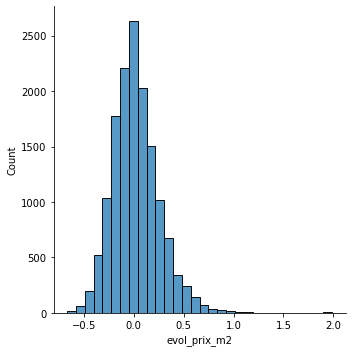

In [326]:
sns.displot(df_rf['evol_prix_m2'], bins = 30, kind = "hist")

In [327]:
df_rf = df_rf[df_rf['evol_prix_m2'].between(-0.2, 0.2)]

In [328]:
# Suppression des colonnes inutiles
df_rf = df_rf.drop(columns = {'dep', 'code_postal', 'prix_m2_dep', 'prix_m2_ref', 'nb_biens_cp', 'prix_m2_cp'})

In [329]:
df_rf.shape

(9664, 50)

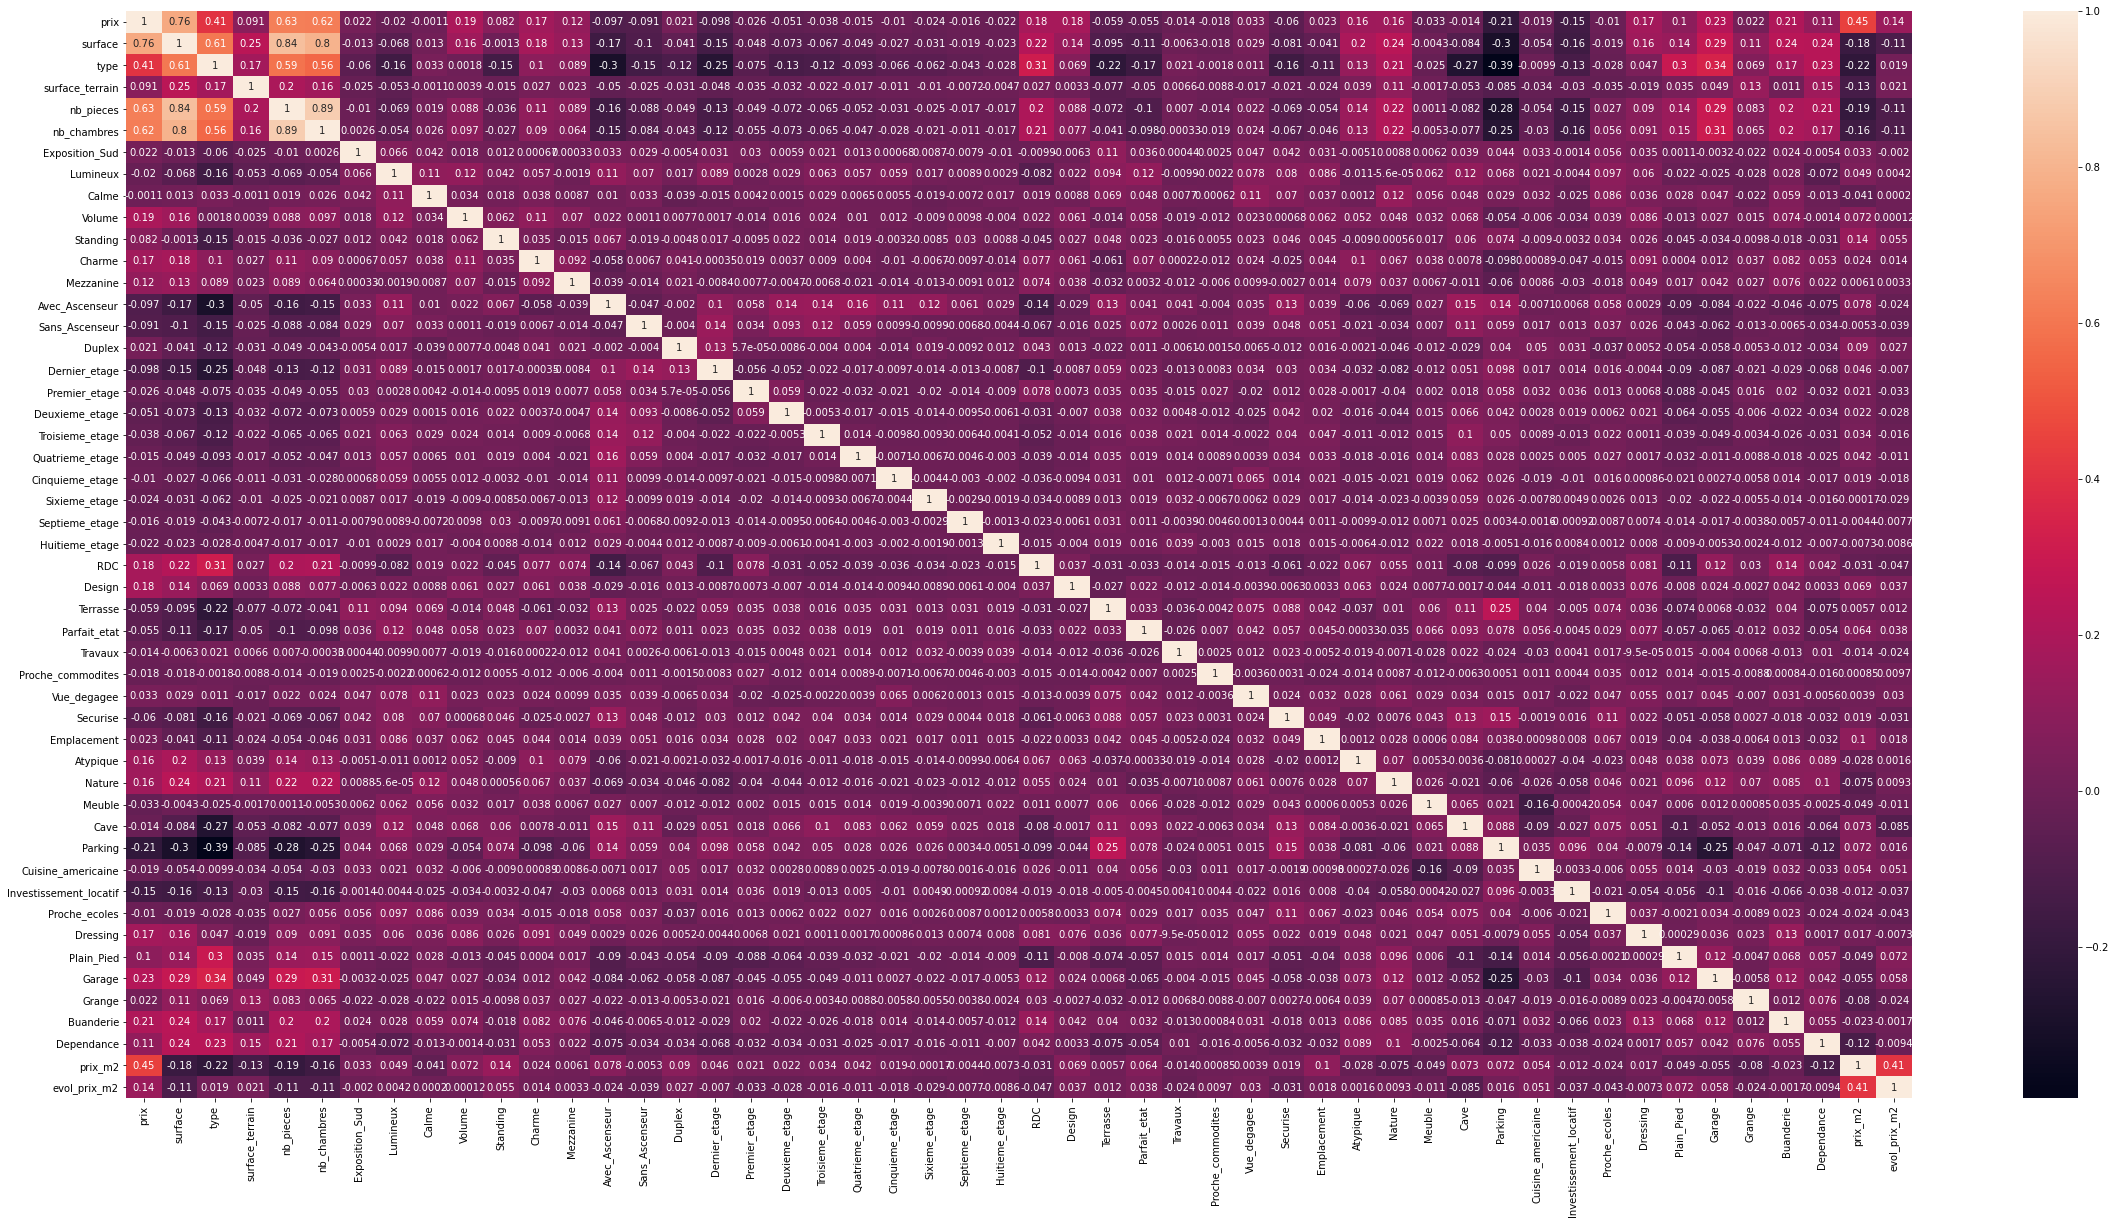

In [330]:
import seaborn as sns
import matplotlib.pyplot as plt

# Affiche la heatmap avec les valeurs
plt.figure(figsize=(40, 20))
matrice_correlation = df_rf.corr()
sns.heatmap(matrice_correlation, annot = True);

In [331]:
# Répartition des annonces de maisons et appartements
df_rf['type'].value_counts()

0    5027
1    4637
Name: type, dtype: int64

In [332]:
col = df_rf.columns.to_list()
col.remove('prix')
col.remove('surface')
col.remove('surface_terrain')
col.remove('nb_pieces')
col.remove('nb_chambres')
col.remove('prix_m2')
col.remove('evol_prix_m2')

print(col)

['type', 'Exposition_Sud', 'Lumineux', 'Calme', 'Volume', 'Standing', 'Charme', 'Mezzanine', 'Avec_Ascenseur', 'Sans_Ascenseur', 'Duplex', 'Dernier_etage', 'Premier_etage', 'Deuxieme_etage', 'Troisieme_etage', 'Quatrieme_etage', 'Cinquieme_etage', 'Sixieme_etage', 'Septieme_etage', 'Huitieme_etage', 'RDC', 'Design', 'Terrasse', 'Parfait_etat', 'Travaux', 'Proche_commodites', 'Vue_degagee', 'Securise', 'Emplacement', 'Atypique', 'Nature', 'Meuble', 'Cave', 'Parking', 'Cuisine_americaine', 'Investissement_locatif', 'Proche_ecoles', 'Dressing', 'Plain_Pied', 'Garage', 'Grange', 'Buanderie', 'Dependance']


In [442]:
# Affichage de l'influence des features sur le prix au m²

recap_annonces = pd.DataFrame()


for c in col[1:]:
    for i in ['Tous Biens', 'Appartements', 'Maisons']:
        
        if i == 'Tous Biens':
            prix_moy = df_rf.groupby(c)['prix_m2'].mean().reset_index()
            nb_biens = df_rf.groupby(c)['prix_m2'].count().reset_index().rename(columns = {'prix_m2': 'nb_biens'})
        elif i == 'Appartements':
            prix_moy = df_rf[df_rf['type'] == 0].groupby(c)['prix_m2'].mean().reset_index()
            nb_biens = df_rf[df_rf['type'] == 0].groupby(c)['prix_m2'].count().reset_index().rename(columns = {'prix_m2': 'nb_biens'})
        elif i == 'Maisons': 
            prix_moy = df_rf[df_rf['type'] == 1].groupby(c)['prix_m2'].mean().reset_index()
            nb_biens = df_rf[df_rf['type'] == 1].groupby(c)['prix_m2'].count().reset_index().rename(columns = {'prix_m2': 'nb_biens'})
        
        infos = prix_moy.merge(nb_biens, on = c, how = "left")
        infos['type_local'] = i
        infos['feature'] = c
        infos = infos.rename(columns = {c: "feature_binary"})
        infos['feature_binary'] = infos['feature_binary'].replace([0, 1], ["non", "oui"])

        infos = infos[['feature', 'type_local', 'feature_binary', 'nb_biens', 'prix_m2']]
        infos['prix_m2'] = infos['prix_m2'].astype(int)
        
        
        recap_annonces = pd.concat([recap_annonces, infos], axis = 0)

recap_annonces.to_csv('models/recap_annonces.csv')

In [443]:
recap_annonces.head()

,feature,type_local,feature_binary,nb_biens,prix_m2
0,Exposition_Sud,Tous Biens,non,8620,3736
1,Exposition_Sud,Tous Biens,oui,1044,3852
0,Exposition_Sud,Appartements,non,4394,3991
1,Exposition_Sud,Appartements,oui,633,3861
0,Exposition_Sud,Maisons,non,4226,3470


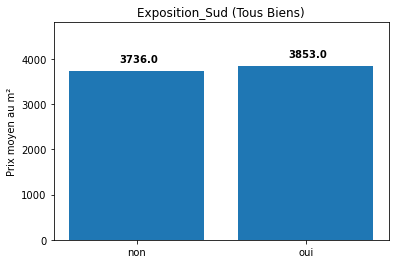

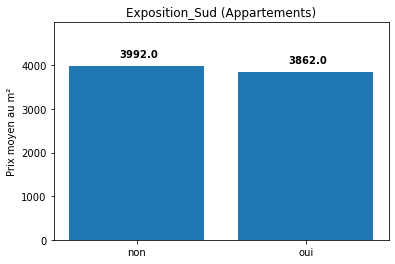

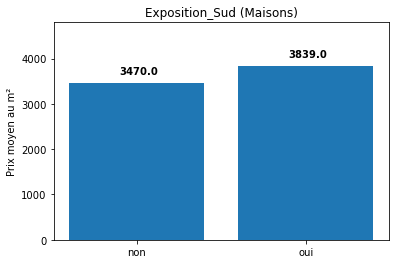

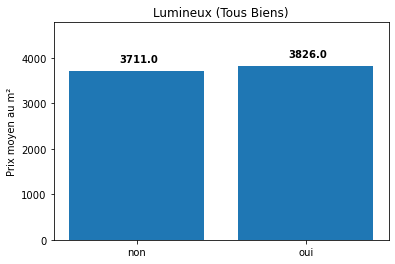

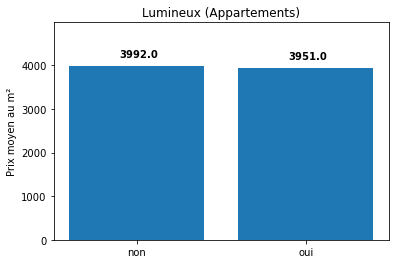

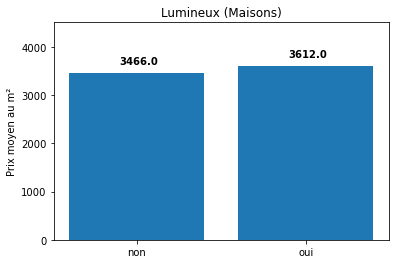

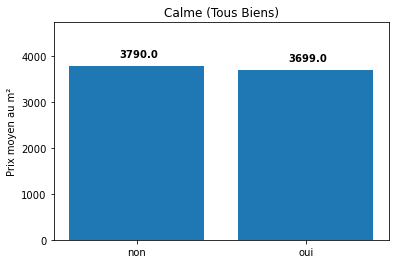

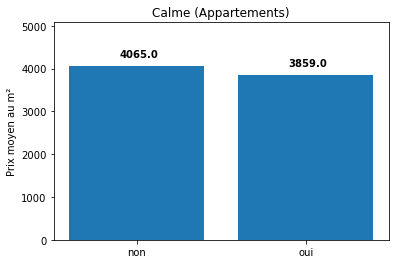

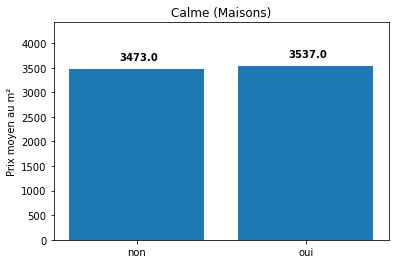

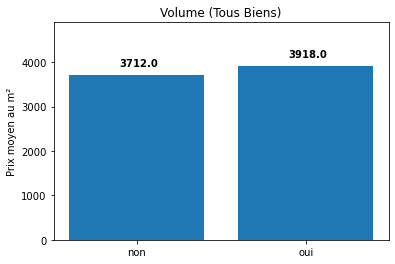

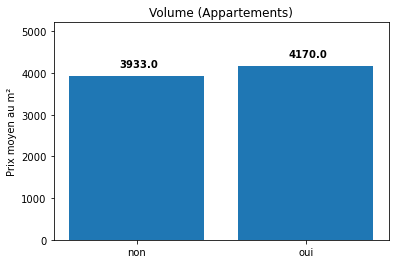

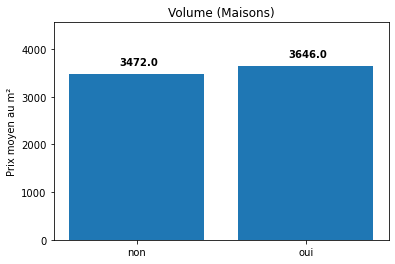

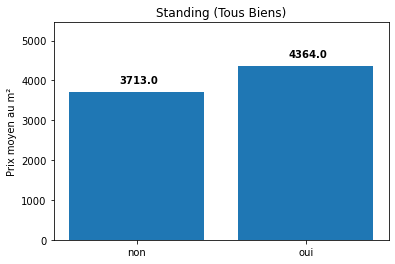

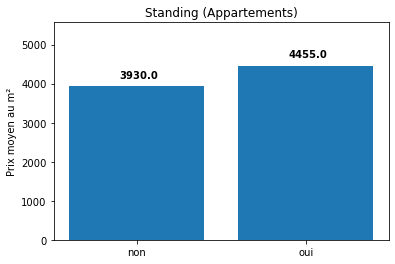

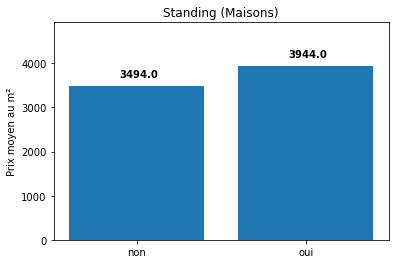

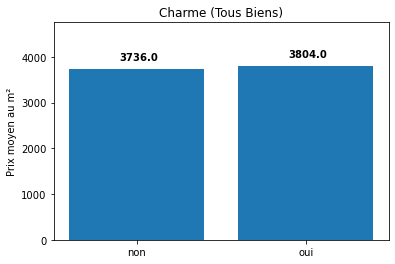

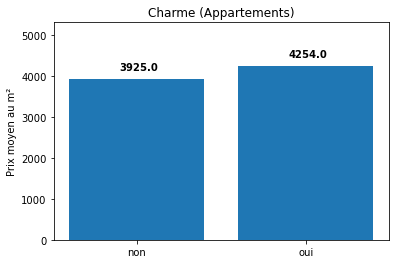

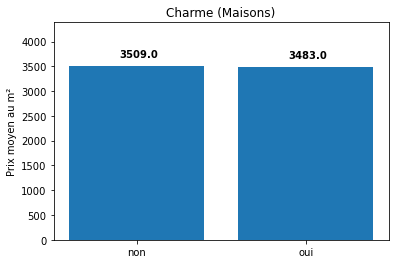

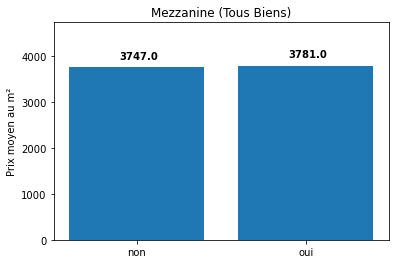

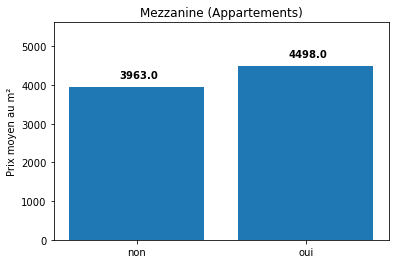

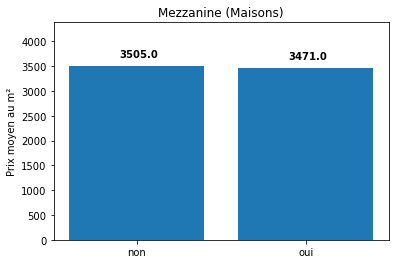

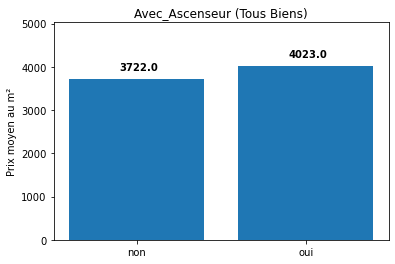

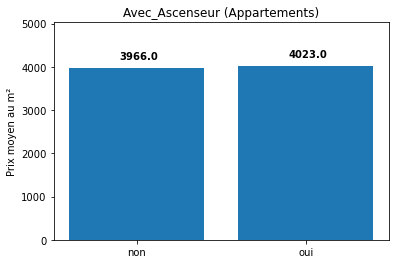

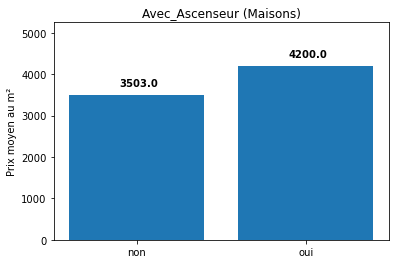

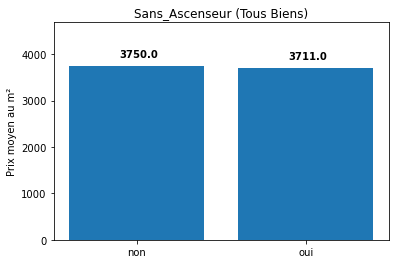

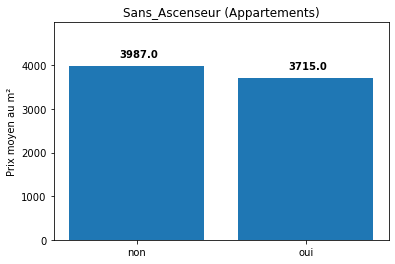

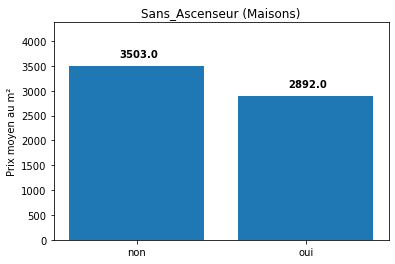

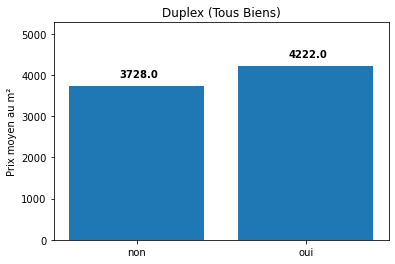

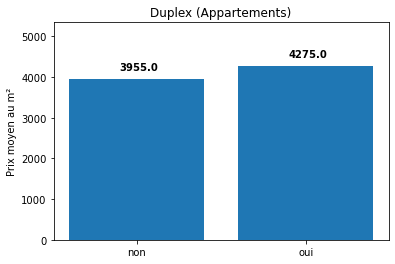

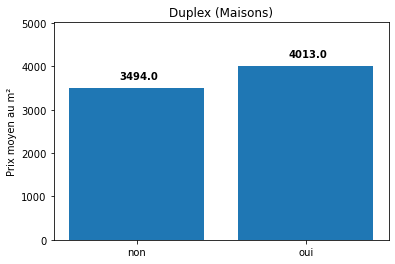

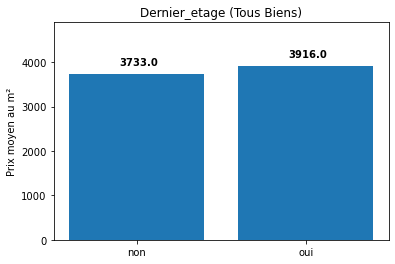

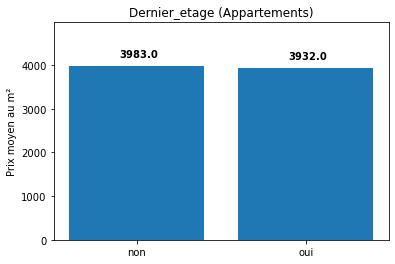

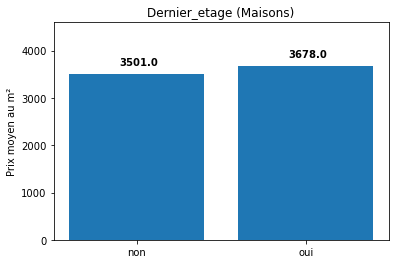

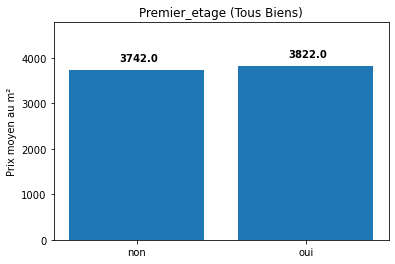

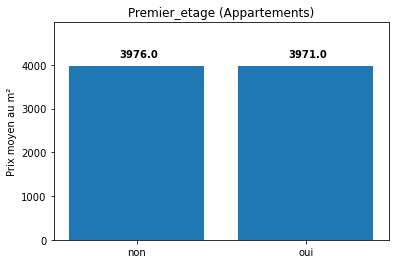

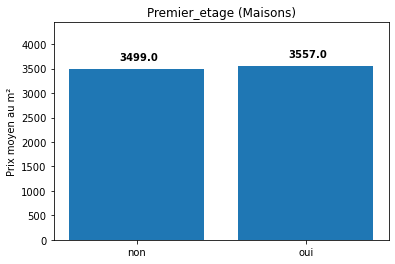

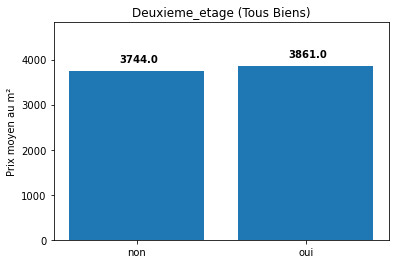

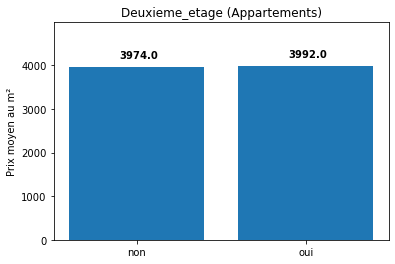

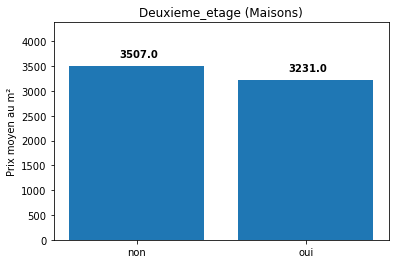

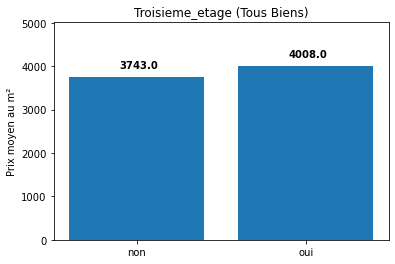

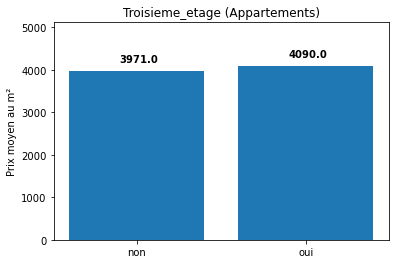

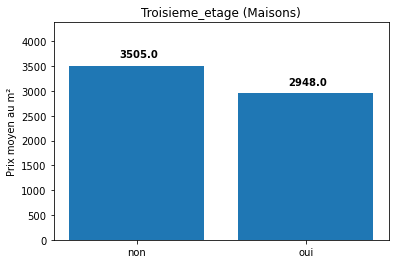

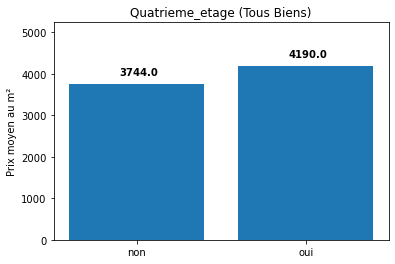

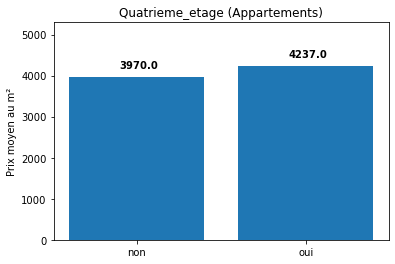

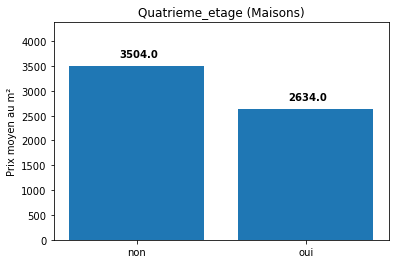

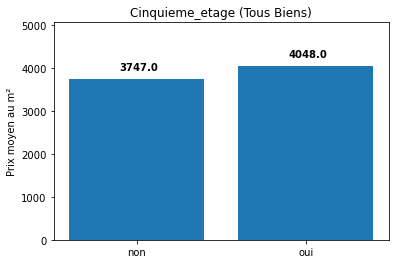

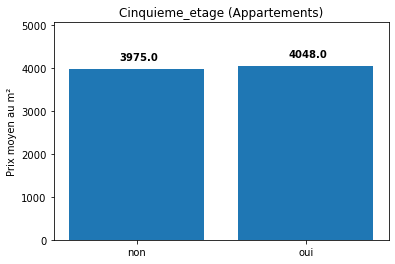

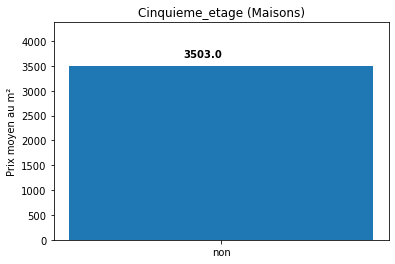

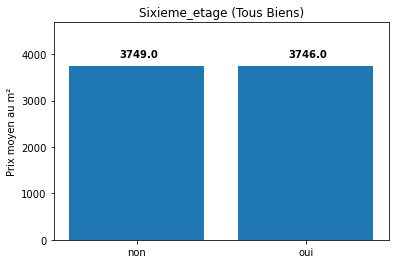

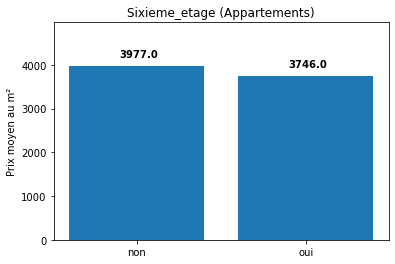

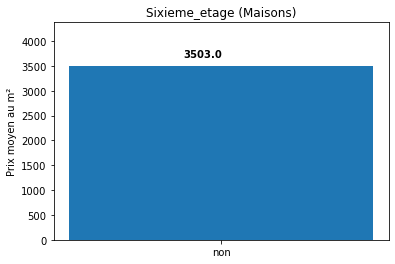

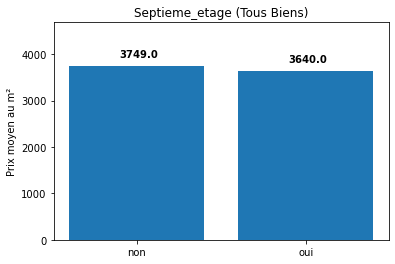

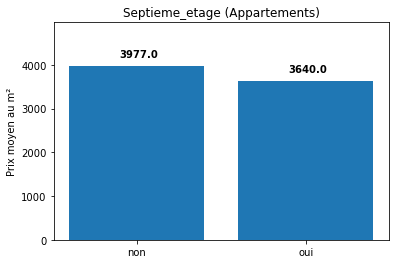

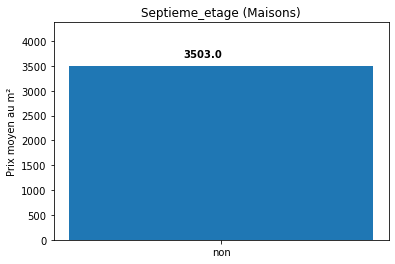

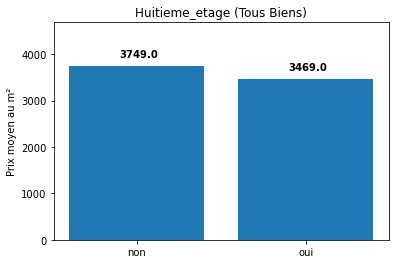

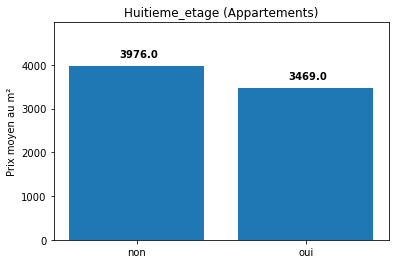

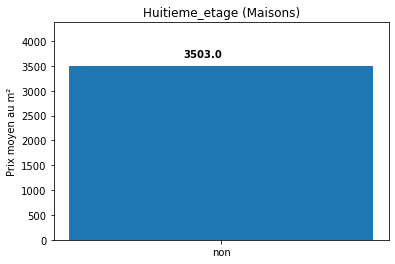

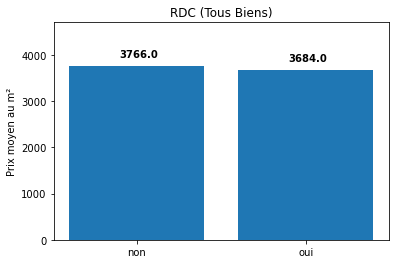

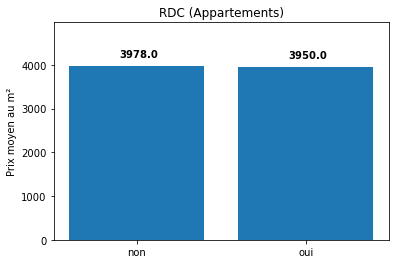

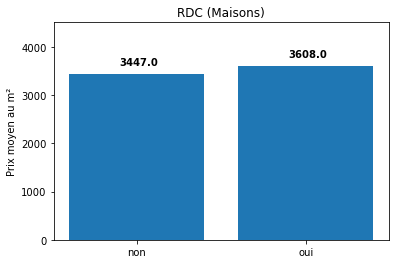

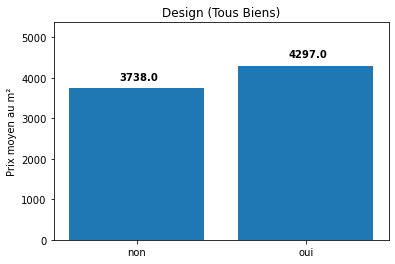

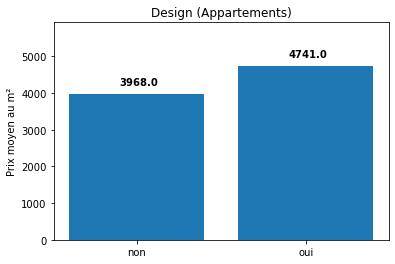

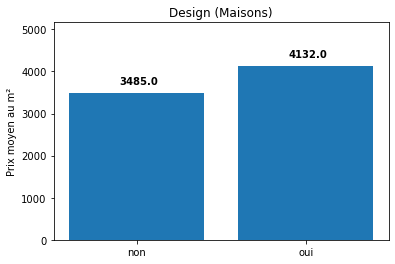

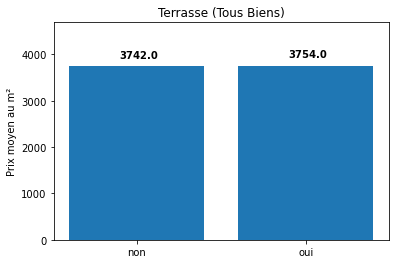

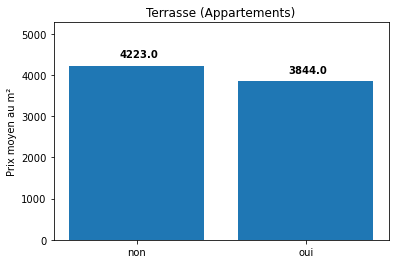

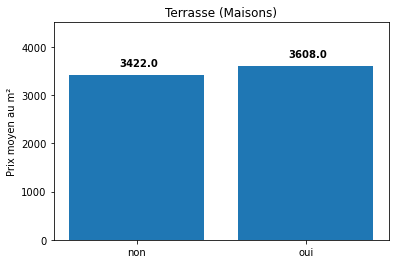

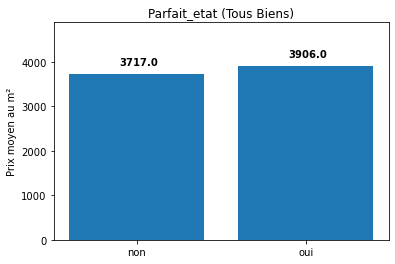

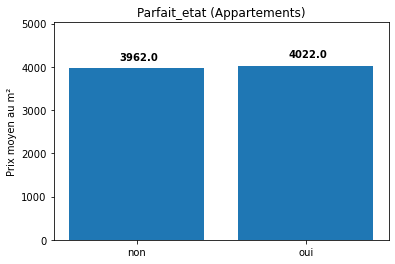

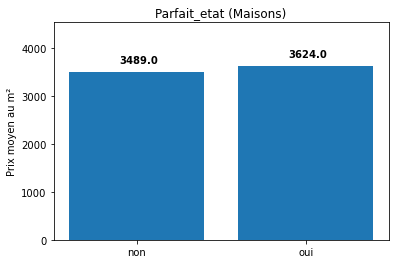

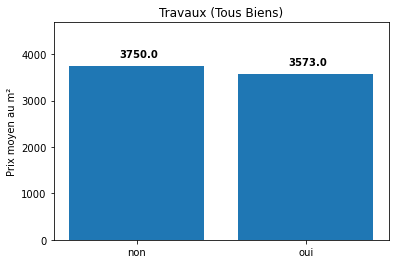

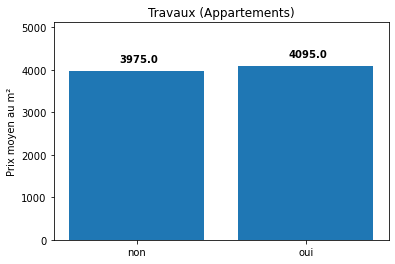

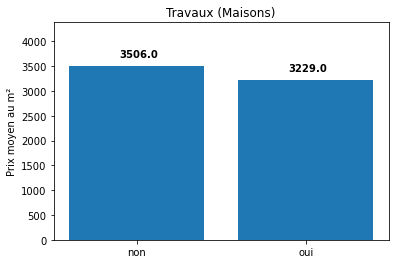

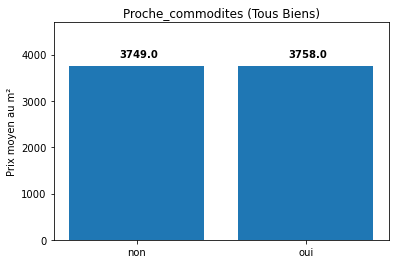

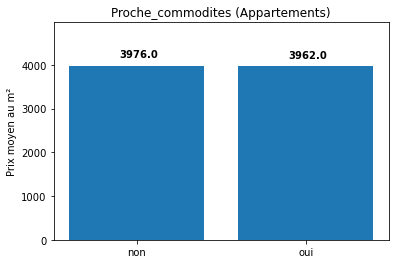

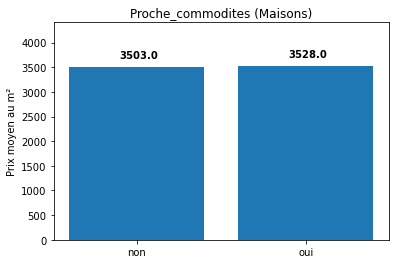

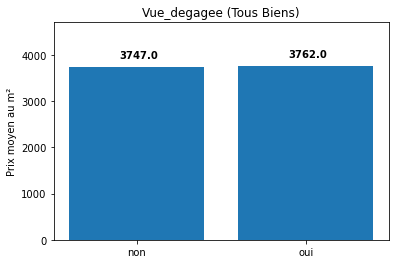

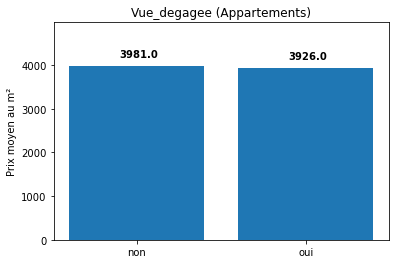

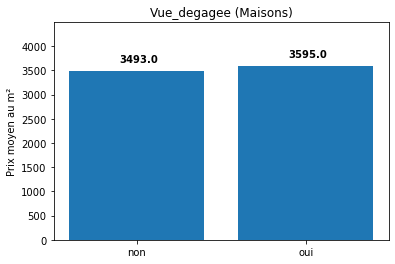

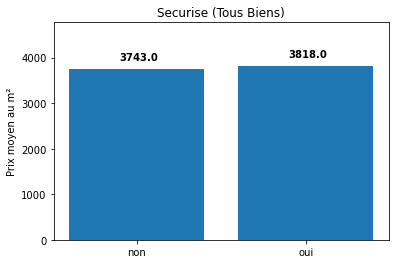

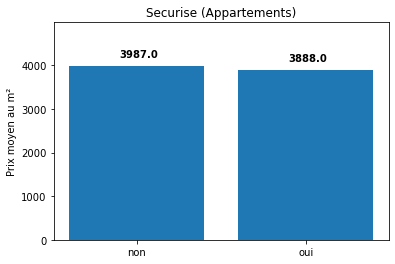

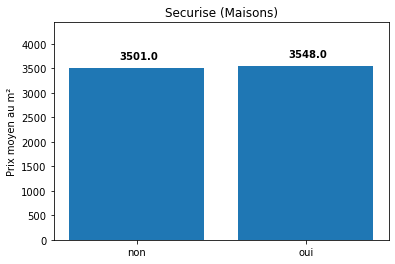

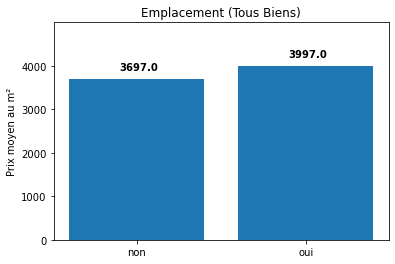

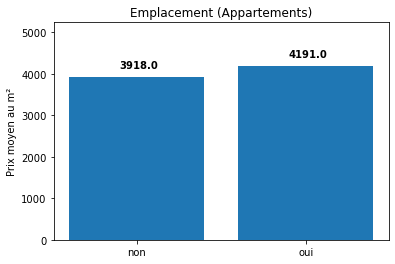

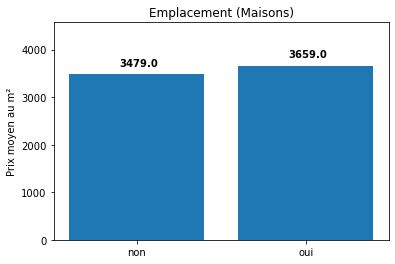

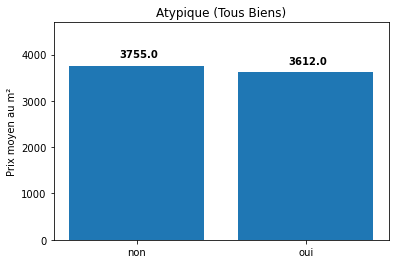

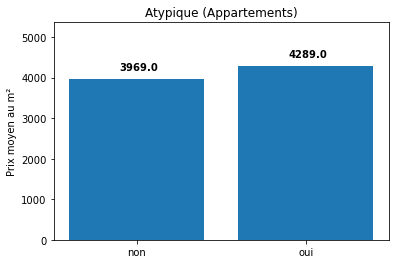

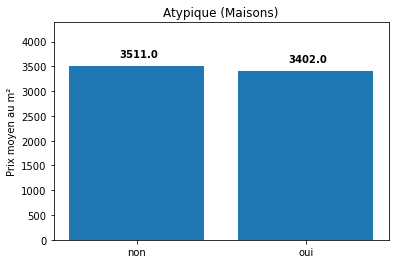

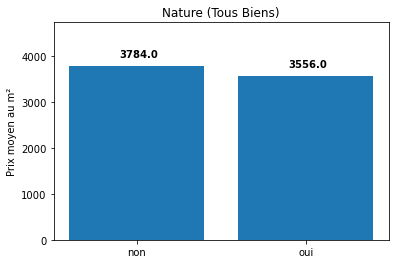

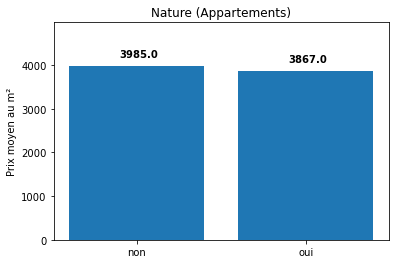

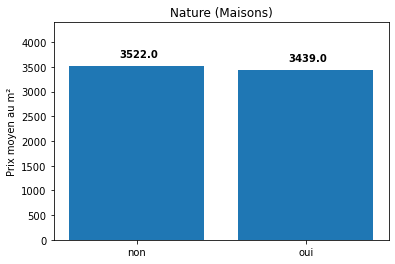

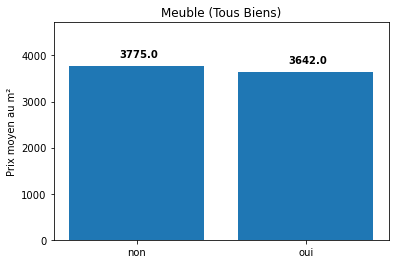

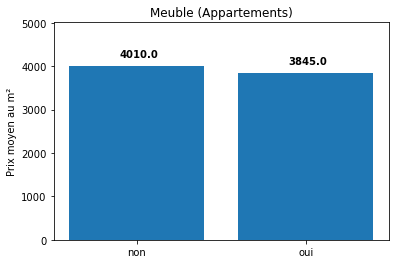

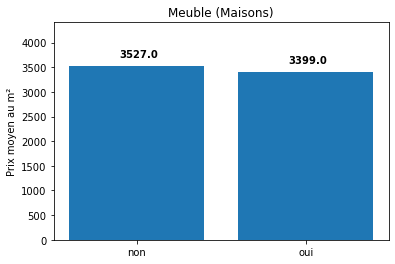

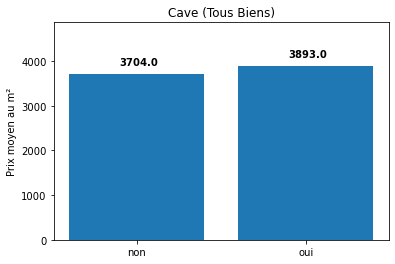

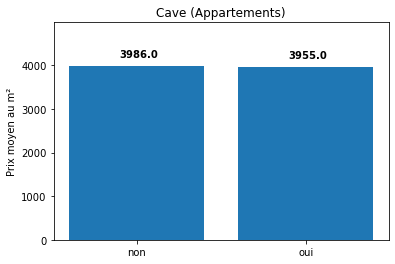

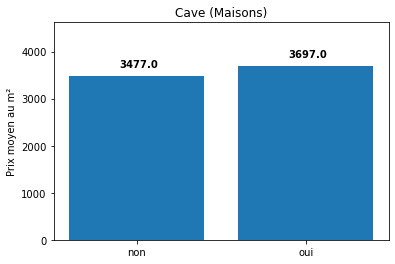

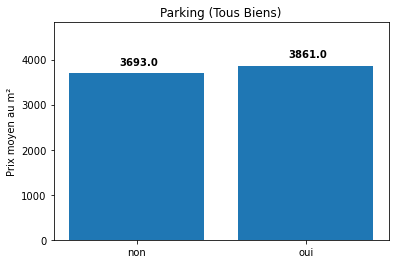

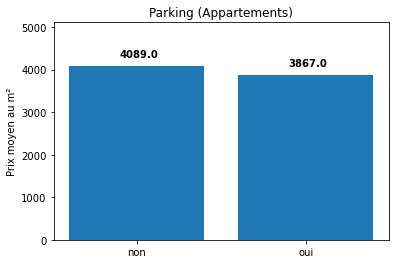

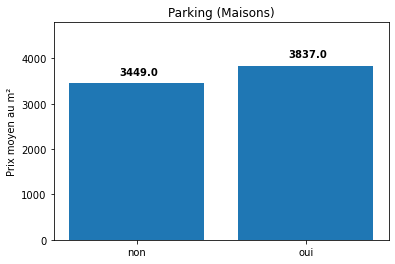

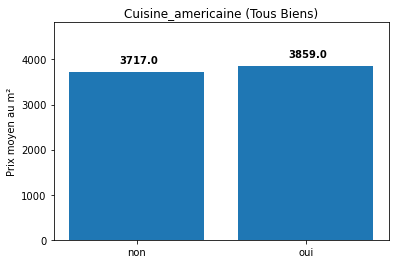

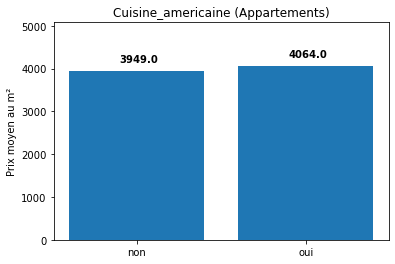

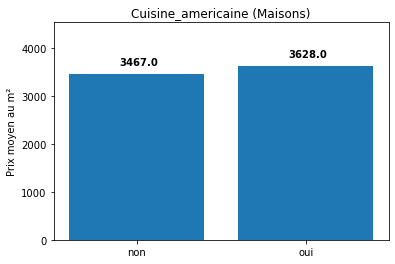

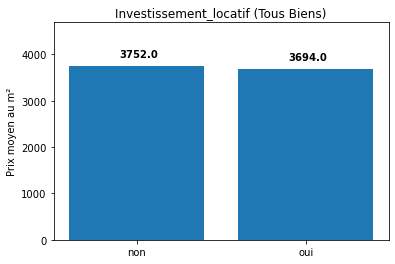

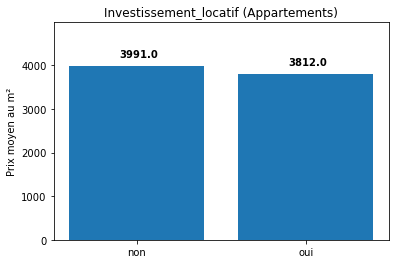

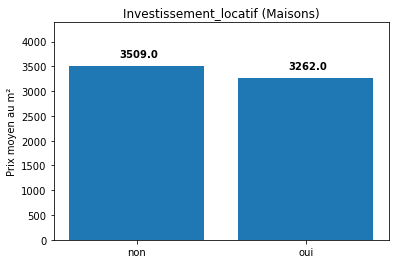

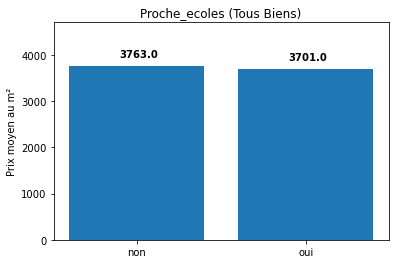

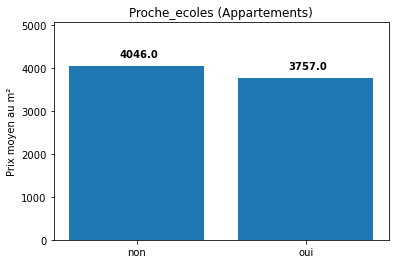

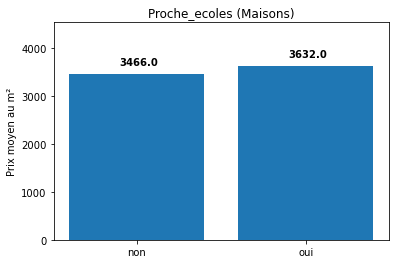

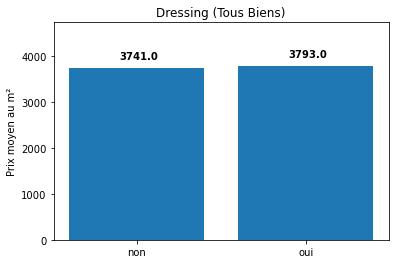

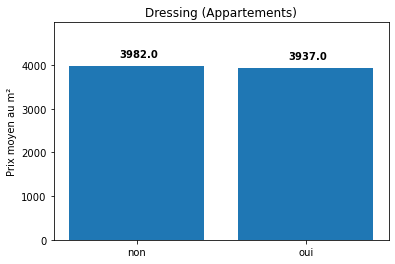

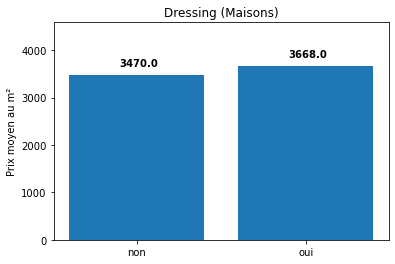

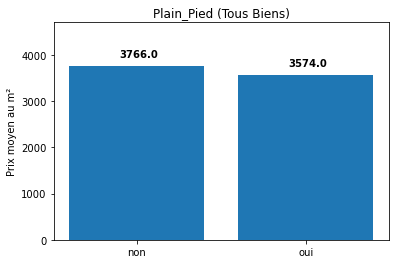

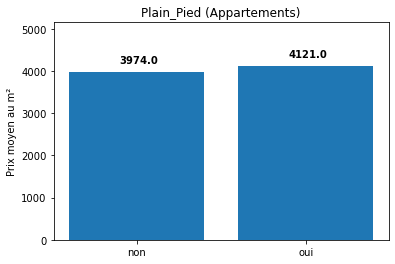

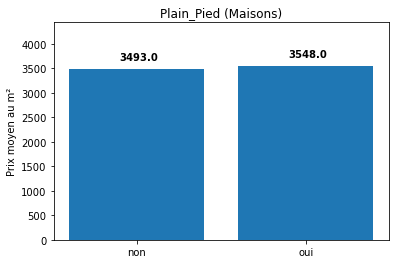

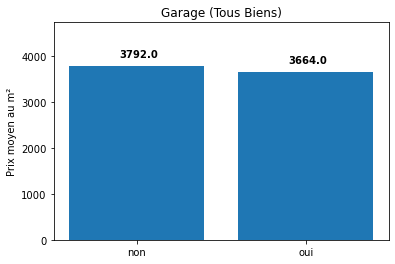

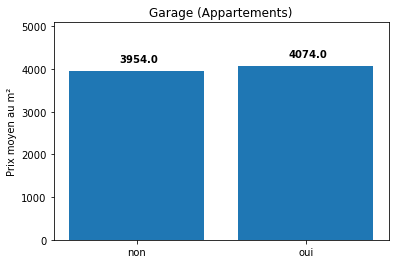

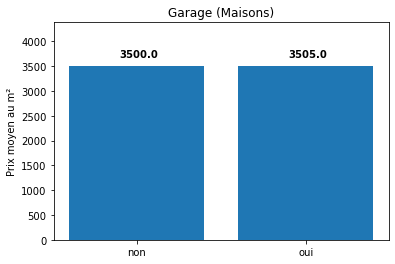

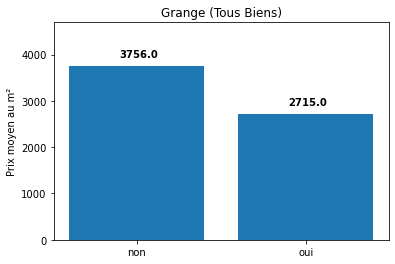

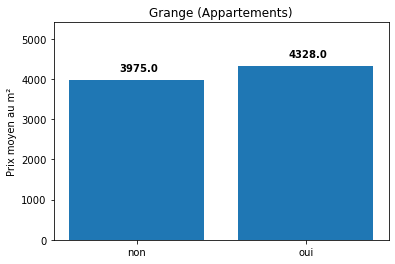

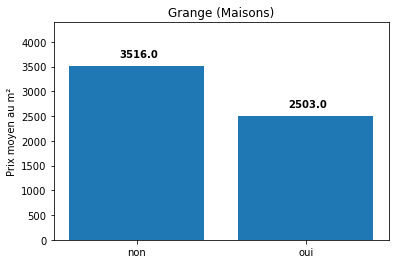

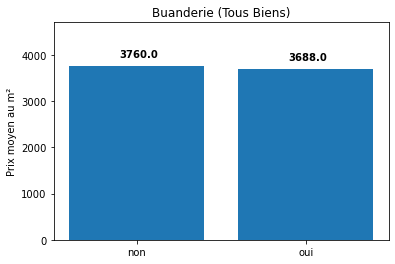

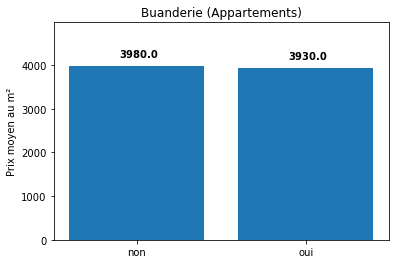

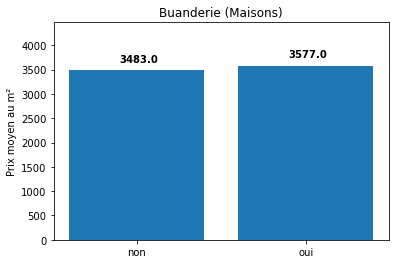

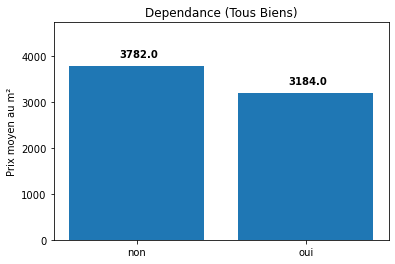

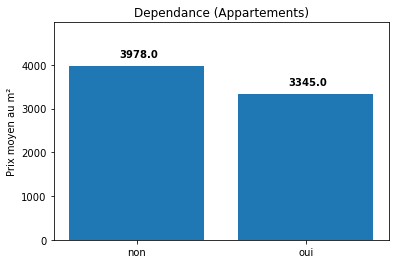

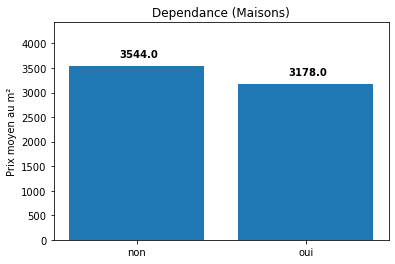

In [441]:
for i, c in enumerate(col[1:]):
    for j, b in enumerate(['Tous Biens', 'Appartements', 'Maisons']):
        df_recap = recap_annonces[(recap_annonces['feature'] == c) & (recap_annonces['type_local'] == b)]
    
        plt.title(c + " (" + b + ")")
        plt.ylabel('Prix moyen au m²')
        plt.bar(df_recap['feature_binary'], df_recap['prix_m2'])
        plt.ylim(ymax = 1.25 * max(df_recap['prix_m2']))

        for k, v in enumerate(df_recap['prix_m2']):
            plt.text(k - 0.1, v + max(df_recap['prix_m2']) / 20, round(v, 0), fontsize = 10, fontweight = 'bold')
        
        plt.show()

In [355]:
# Affichage de l'influence des features sur le prix au m²

for c in col:
    print('Influence de', c, 'sur le prix au m2')
    print('Tous biens confondus')
    print(df_rf.groupby(c)['prix_m2'].mean().reset_index())
    print(df_rf.groupby(c)['prix_m2'].count().reset_index())
    print('\n')
    
    print('Influence de', c, 'sur le prix au m2')
    print('Appartements')
    print(df_rf[df_rf['type'] == 0].groupby(c)['prix_m2'].mean().reset_index())
    print('\n')
    
    print('Influence de', c, 'sur le prix au m2')
    print('Maisons')
    print(df_rf[df_rf['type'] == 1].groupby(c)['prix_m2'].mean().reset_index())
    print('\n')
    
    print('-----------------------------------')

Influence de type sur le prix au m2
Tous biens confondus
   type      prix_m2
0     0  3975.451995
1     1  3502.968657
   type  prix_m2
0     0     5027
1     1     4637


Influence de type sur le prix au m2
Appartements
   type      prix_m2
0     0  3975.451995


Influence de type sur le prix au m2
Maisons
   type      prix_m2
0     1  3502.968657


-----------------------------------
Influence de Exposition_Sud sur le prix au m2
Tous biens confondus
   Exposition_Sud      prix_m2
0               0  3736.167496
1               1  3852.585270
   Exposition_Sud  prix_m2
0               0     8620
1               1     1044


Influence de Exposition_Sud sur le prix au m2
Appartements
   Exposition_Sud      prix_m2
0               0  3991.844090
1               1  3861.665478


Influence de Exposition_Sud sur le prix au m2
Maisons
   Exposition_Sud      prix_m2
0               0  3470.326760
1               1  3838.600424


-----------------------------------
Influence de Lumineux sur le

   Nature      prix_m2
0       0  3522.296607
1       1  3438.770322


-----------------------------------
Influence de Meuble sur le prix au m2
Tous biens confondus
   Meuble      prix_m2
0       0  3775.234231
1       1  3642.039241
   Meuble  prix_m2
0       0     7742
1       1     1922


Influence de Meuble sur le prix au m2
Appartements
   Meuble      prix_m2
0       0  4009.810774
1       1  3845.000102


Influence de Meuble sur le prix au m2
Maisons
   Meuble      prix_m2
0       0  3527.192758
1       1  3398.671983


-----------------------------------
Influence de Cave sur le prix au m2
Tous biens confondus
   Cave      prix_m2
0     0  3703.955112
1     1  3892.803559
   Cave  prix_m2
0     0     7372
1     1     2292


Influence de Cave sur le prix au m2
Appartements
   Cave      prix_m2
0     0  3986.192890
1     1  3955.143735


Influence de Cave sur le prix au m2
Maisons
   Cave      prix_m2
0     0  3476.727439
1     1  3696.764562


-----------------------------------

In [334]:
df_rf.head()

,prix,surface,type,surface_terrain,nb_pieces,nb_chambres,Exposition_Sud,Lumineux,Calme,Volume,Standing,Charme,Mezzanine,Avec_Ascenseur,Sans_Ascenseur,Duplex,Dernier_etage,Premier_etage,Deuxieme_etage,Troisieme_etage,Quatrieme_etage,Cinquieme_etage,Sixieme_etage,Septieme_etage,Huitieme_etage,RDC,Design,Terrasse,Parfait_etat,Travaux,Proche_commodites,Vue_degagee,Securise,Emplacement,Atypique,Nature,Meuble,Cave,Parking,Cuisine_americaine,Investissement_locatif,Proche_ecoles,Dressing,Plain_Pied,Garage,Grange,Buanderie,Dependance,prix_m2,evol_prix_m2
0,435750,102,1,940,4,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4272.058824,0.09
2,275600,120,1,1479,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,2296.666667,0.11
3,679250,195,1,1500,8,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,3483.333333,-0.01
5,377690,67,0,0,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5637.164179,0.16
6,311000,80,0,0,4,3,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,3887.500000,0.05


In [335]:
# Séparation des bases Maisons et Appartements
df_appart = df_rf[df_rf['type'] == 0]
print(df_appart.shape)

df_maison = df_rf[df_rf['type'] == 1]
print(df_maison.shape)


(5027, 50)
(4637, 50)


In [336]:
# Fonction d'entraînement de modèle Random Forest

def random_forest_model(X_train, X_test, y_train, y_test):
    print('X_train.shape: ', X_train.shape)
    print('X_test.shape: ', X_test.shape)
    print('y_train.shape: ', y_train.shape)
    print('y_test.shape: ', y_test.shape)
    
    regr = RandomForestRegressor(n_estimators = 50, max_depth = 200, min_samples_leaf = 25, random_state = 123)
    regr.fit(X_train, y_train)
    
    y_pred_train = regr.predict(X_train) 
    y_pred_test = regr.predict(X_test)
    
    score_train = regr.score(X_train, y_train)
    score_test = regr.score(X_test, y_test)
    rmse_train = mean_squared_error(y_pred_train, y_train, squared=False)
    rmse_test = mean_squared_error(y_pred_test, y_test, squared=False)
    mae_train = mean_absolute_error(y_pred_train, y_train)
    mae_test = mean_absolute_error(y_pred_test, y_test)
    
    results = {'score_train': score_train, 'score_test': score_test,
              'rmse_train': rmse_train, 'rmse_test': rmse_test,
              'mae_train': mae_train, 'mae_test': mae_test}

    print("score train:", score_train)
    print("score test:", score_test)

    print("rmse train : ", rmse_train)
    print('rmse test :', rmse_test)

    print("mae train : ", mae_train)
    print('mae test :', mae_test)
    
    return regr, results

In [337]:
### Archive Recherche Meilleurs Hyperparamètres
"""
rf = RandomForestRegressor(max_features='sqrt')  

param_grid = {  
           "n_estimators" : [10, 20, 50, 100, 500],  
           "max_depth" : [5, 100, 200, 500],  
           "min_samples_leaf" : [25, 50, 100]}

CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid)  
CV_rf.fit(X_train, y_train)  
print(CV_rf.best_params_)
"""

'\nrf = RandomForestRegressor(max_features=\'sqrt\')  \n\nparam_grid = {  \n           "n_estimators" : [10, 20, 50, 100, 500],  \n           "max_depth" : [5, 100, 200, 500],  \n           "min_samples_leaf" : [25, 50, 100]}\n\nCV_rf = GridSearchCV(estimator=rf, param_grid=param_grid)  \nCV_rf.fit(X_train, y_train)  \nprint(CV_rf.best_params_)\n'

In [338]:
target_a = df_appart['evol_prix_m2']
features_a = df_appart.drop(columns = {'prix', 'nb_pieces', 'surface', 'surface_terrain', 'nb_chambres', 'prix_m2', 'evol_prix_m2'})

target_m = df_maison['evol_prix_m2']
features_m = df_maison.drop(columns = {'prix', 'nb_pieces', 'surface', 'surface_terrain', 'nb_chambres', 'prix_m2', 'evol_prix_m2'})

In [339]:
# Modèle maisons
X_train, X_test, y_train, y_test = train_test_split(features_m, target_m, test_size = 0.2, random_state = 234)

scaler = MinMaxScaler().fit(X_train) 
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)

rf_maison, results_maison = random_forest_model(X_train, X_test, y_train, y_test)

X_train.shape:  (3709, 43)
X_test.shape:  (928, 43)
y_train.shape:  (3709,)
y_test.shape:  (928,)
score train: 0.08555155904628309
score test: 0.01470427478182268
rmse train :  0.1029711641010915
rmse test : 0.10503281452133616
mae train :  0.08549968947723369
mae test : 0.08744421876127847


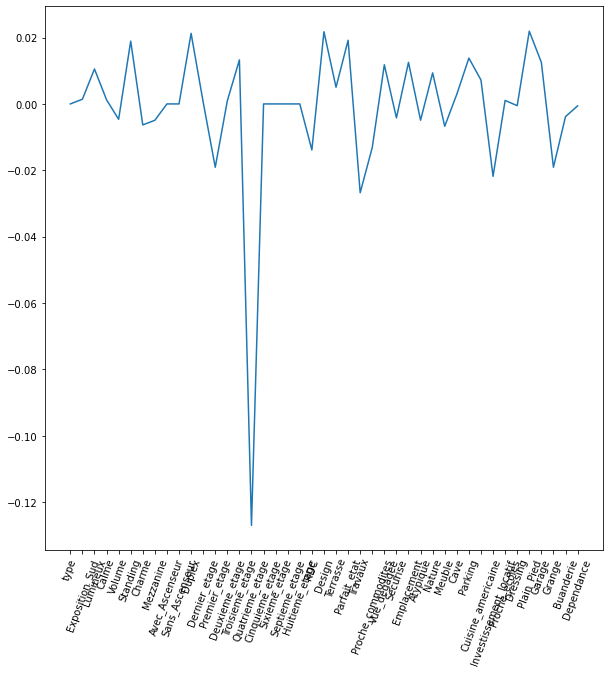

In [340]:
from sklearn.linear_model import Lasso 
lasso_r = Lasso(alpha = 0.00001) 
lasso_r.fit(X_train, y_train)

# Afficher les coefficients estimés par le modèle
lasso_r.coef_
plt.figure(figsize=(10, 10))
plt.plot(range(len(features_m.columns)), lasso_r.coef_) 
plt.xticks(range(len(features_m.columns)), features_m.columns.values, rotation=70);

In [341]:
# Modèle appartement
X_train, X_test, y_train, y_test = train_test_split(features_a, target_a, test_size = 0.2, random_state = 234)

scaler = MinMaxScaler().fit(X_train) 
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)

rf_appart, results_appart = random_forest_model(X_train, X_test, y_train, y_test)

X_train.shape:  (4021, 43)
X_test.shape:  (1006, 43)
y_train.shape:  (4021,)
y_test.shape:  (1006,)
score train: 0.10495912470671342
score test: 0.03007362947564296
rmse train :  0.10270223963367545
rmse test : 0.10575351475938986
mae train :  0.08573351453297384
mae test : 0.08732263782912243


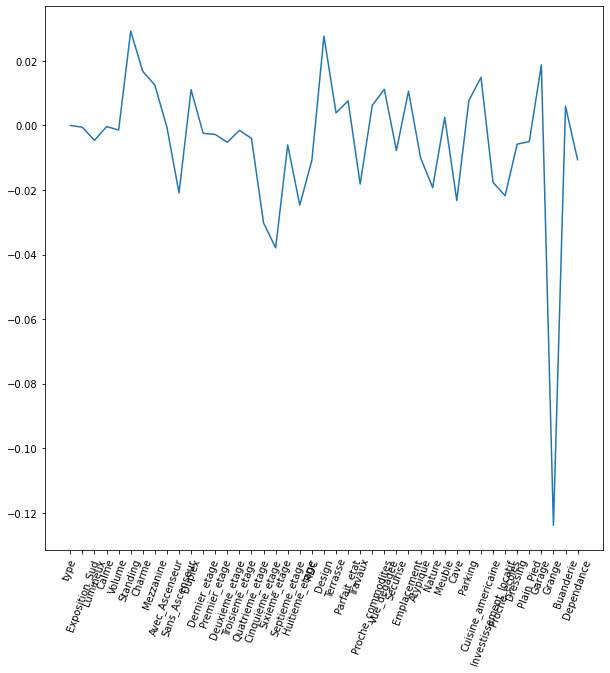

In [342]:
from sklearn.linear_model import Lasso 
lasso_r = Lasso(alpha = 0.00001) 
lasso_r.fit(X_train, y_train)

# Afficher les coefficients estimés par le modèle
lasso_r.coef_
plt.figure(figsize=(10, 10))
plt.plot(range(len(features_m.columns)), lasso_r.coef_) 
plt.xticks(range(len(features_m.columns)), features_m.columns.values, rotation=70);

Les résultats sont décevants.

Hypohtèses pour expliquer cela :

1. Ce qui est écrit dans l'annonce n'est pas exhaustif et représentatif des propriétés des biens.

Exemple : les annonces auront tendance à ne pas mentionner qu'il n'y a pas d'ascenseur. 
Pourtant, cela a un impact sur le prix affiché.

2. Pas assez de données

Le bonus / malus est calculé sur la base d'un prix de référence. Si on n'a pas assez d'annonces pour un code postal donné, le prix de référence devient celui du département, qui ne représente pas les disparités possibles des prix par commune.

# Tests d'autres méthodes de régression

In [343]:
# Test régression Lasso

from sklearn.linear_model import RidgeCV 
ridge_reg = RidgeCV(alphas= (0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 50, 100)) 
ridge_reg.fit(X_train, y_train)

# Afficher le αα retenu par le modèle grâce à l'attribut alpha_
print(ridge_reg.alpha_) 

# Afficher le score (R²) du modèle sur l'ensemble d'entraînement puis sur l'ensemble de test
print(ridge_reg.score(X_train, y_train)) 
print(ridge_reg.score(X_test, y_test))

ridge_pred_train = ridge_reg.predict(X_train) 
ridge_pred_test = ridge_reg.predict(X_test) 
print('mae train :', mean_absolute_error(ridge_pred_train, y_train)) 
print('mae test :', mean_absolute_error(ridge_pred_test, y_test))

100.0
0.05225954057432913
0.036521812863264946
mae train : 0.08843137318781438
mae test : 0.08708509657474305


In [344]:
# Test Select K Best sur Maisons
X_train, X_test, y_train, y_test = train_test_split(features_m, target_m, test_size = 0.2, random_state = 234)

from sklearn.feature_selection import SelectKBest, f_regression 
sk = SelectKBest(f_regression, k = 10) 
sk.fit(X = features_m, y = target_m) 
features_m.columns[sk.get_support()]

# Utiliser la méthode transform du sélecteur sk pour créer les tableaux sk_train et sk_test à partir de X_train et X_test
sk_train = sk.transform(X_train)
sk_test = sk.transform(X_test)

lr3 = LinearRegression() 
lr3.fit(sk_train, y_train) 
print(lr3.score(sk_train, y_train)) 
print(lr3.score(sk_test, y_test))

0.031520236480441
0.02804632217606029


C:\Users\olivier\anaconda\envs\py39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\olivier\anaconda\envs\py39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\olivier\anaconda\envs\py39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:358: RuntimeWarning: invalid value encountered in true_divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


# Essai de prédiction

In [345]:
X_train.columns

Index(['type', 'Exposition_Sud', 'Lumineux', 'Calme', 'Volume', 'Standing',
       'Charme', 'Mezzanine', 'Avec_Ascenseur', 'Sans_Ascenseur', 'Duplex',
       'Dernier_etage', 'Premier_etage', 'Deuxieme_etage', 'Troisieme_etage',
       'Quatrieme_etage', 'Cinquieme_etage', 'Sixieme_etage', 'Septieme_etage',
       'Huitieme_etage', 'RDC', 'Design', 'Terrasse', 'Parfait_etat',
       'Travaux', 'Proche_commodites', 'Vue_degagee', 'Securise',
       'Emplacement', 'Atypique', 'Nature', 'Meuble', 'Cave', 'Parking',
       'Cuisine_americaine', 'Investissement_locatif', 'Proche_ecoles',
       'Dressing', 'Plain_Pied', 'Garage', 'Grange', 'Buanderie',
       'Dependance'],
      dtype='object')

In [346]:
# Export de la liste des colonnes de X_train
feature_list = list(X_train.columns)

df_feat = pd.DataFrame({'feature_name': feature_list})
#df_feat = pd.DataFrame({'feature_name': feature_list}, index = [i for i in range (0, len(feature_list))])
df_feat.to_csv('models/features_list_for_model_B.csv')

In [347]:
prix = 400000
surface = 120
type_local = 1
surface_terrain = 300
nb_pieces = 5
nb_chambres = 4 

# Features
Exposition_Sud = 0
Lumineux = 0
Calme = 1
Volume =  0
Standing = 1
Charme = 1
Mezzanine =  0
Avec_Ascenseur = 0
Sans_Ascenseur = 0
Duplex = 0
Dernier_etage = 0 
Premier_etage = 0
Deuxieme_etage = 0
Troisieme_etage = 0
Quatrieme_etage = 0
Cinquieme_etage = 0
Sixieme_etage = 0
Septieme_etage = 0
Huitieme_etage = 0
RDC = 0
Design = 0
Terrasse = 1
Parfait_etat = 1
Travaux = 0
Proche_commodites = 0
Vue_degagee = 1
Securise = 1
Emplacement = 0
Atypique = 0
Nature = 1
Meuble = 0
Cave = 0
Parking = 1
Cuisine_americaine = 0
Investissement_locatif = 0
Proche_ecoles = 1
Dressing = 1
Plain_Pied = 0
Garage = 1
Grange = 0
Buanderie = 1
Dependance = 1

In [352]:
annonce = [
    #prix, surface, type_local, surface_terrain, nb_pieces, nb_chambres,
       type_local, Exposition_Sud, Lumineux, Calme, Volume, Standing, Charme,
       Mezzanine, Avec_Ascenseur, Sans_Ascenseur, Duplex,
       Dernier_etage, Premier_etage, Deuxieme_etage, Troisieme_etage,
       Quatrieme_etage, Cinquieme_etage, Sixieme_etage, Septieme_etage,
       Huitieme_etage, RDC, Design, Terrasse, Parfait_etat,
       Travaux, Proche_commodites, Vue_degagee, Securise,
       Emplacement, Atypique, Nature, Meuble, Cave, Parking,
       Cuisine_americaine, Investissement_locatif, Proche_ecoles,
       Dressing, Plain_Pied, Garage, Grange, Buanderie,
       Dependance]
annonce = np.array(annonce).reshape(1, 43)

In [353]:
evol = rf_maison.predict(np.array(annonce)) 
evol

array([0.01524331])

In [354]:
joblib.dump(rf_maison, 'models/model_features_maison.pkl', compress = 3)
joblib.dump(rf_appart, 'models/model_features_appart.pkl', compress = 3)

['models/model_features_appart.pkl']